<h2>Tokenization

- `Assign Character labels and spaces to cut points`
- `Apply BPE`

In [ ]:
#libraries

import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import urllib.request
import shutil
import zipfile
import utils
from transformers import AutoTokenizer
import string

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = None

# For reproducibility
np.random.seed(42)
N_JOBS = 2


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Import data

In [ ]:
#magnitude cuts for tokens
cut_points_df=pd.read_csv("cut_points.csv")


In [11]:
data = utils.load_data('/data/UKBB/kyra/capture24/P001.csv.gz')
X, Y, T = utils.make_windows(data, winsec=1) #1 second windows. 

<h4> Assign Labels

In [ ]:

# Function to assign the label corresponding to the highest absolute cut
def assign_label(mean_values, cuts, labs):
    assigned_labels = []
    for value in mean_values:
        # Find the cuts that the value passes through
        passed_cuts = cuts[np.abs(cuts) <= np.abs(value)]
        # Assign the label corresponding to the cut with the highest absolute value
        if len(passed_cuts) > 0:
            # Use np.isclose to find the index of the cut
            cut_index = np.where(np.isclose(cuts, passed_cuts[-1]))[0][0]
            assigned_labels.append(labs[cut_index])
        else:
            assigned_labels.append('A')  # Default to 'A' for 0
    return assigned_labels

# Assign labels to mean_values
assigned_labels = assign_label(mean_values, cuts, labs)
print(assigned_labels)

In [16]:
cut_points_df

,arbitrary_cuts,sd_cuts,ci_cuts
0,-0.990684,-0.759364,-0.990684
1,-0.292509,-0.604944,-0.640305
2,0.405666,-0.450523,-0.289926
3,1.103841,-0.373313,-0.252093
4,1.802016,-0.296103,-0.214260
5,2.500191,-0.218893,-0.176427
6,3.198366,-0.141683,-0.138594
7,3.896541,-0.064472,-0.100761
8,4.594716,-0.013239,-0.062928
9,5.292891,0.000221,-0.025095


Arbitary

In [42]:
cuts_a= cut_points_df['arbitrary_cuts']
labs_a=list(string.ascii_lowercase[:len(cuts_a)])

Average & Standard Deviation driven

In [43]:
cuts_s = cut_points_df['sd_cuts']
labs_s = list(string.ascii_lowercase[:len(cuts_s)])

Confidence Interval Driven

In [44]:
cuts_c = cut_points_df['ci_cuts']
labs_c = list(string.ascii_lowercase[:len(cuts_c)])

<h4>Compression /Windows

10 seconds

In [18]:
X, Y, T = utils.make_windows(data, winsec=10)

In [29]:
M = np.linalg.norm(X, axis=2)

M_norm= M-1

mean_m= np.mean(M_norm, axis=1)


In [30]:
print(mean_m.shape)

(7474,)


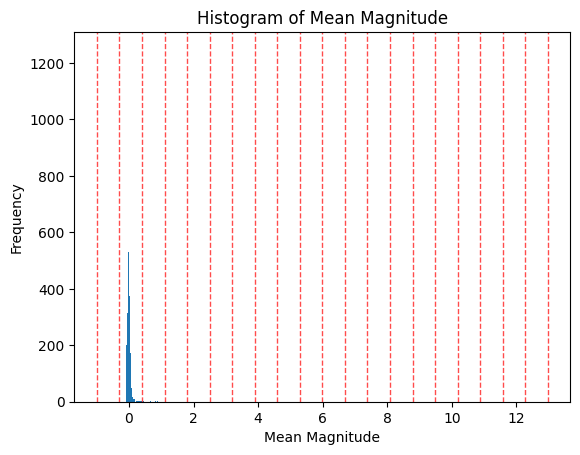

In [45]:
plt.hist(mean_m, bins=100)
plt.xlabel('Mean Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Magnitude')

# Plot vertical lines for each cut point
for cut in cuts_a:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.show()

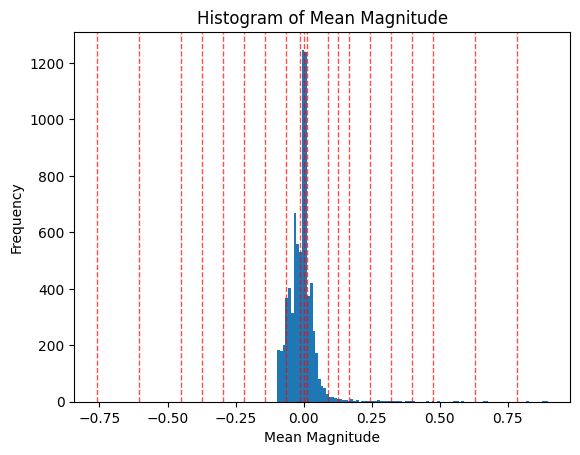

In [46]:
plt.hist(mean_m, bins=100)
plt.xlabel('Mean Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Magnitude')

# Plot vertical lines for each cut point
for cut in cuts_s:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.show()

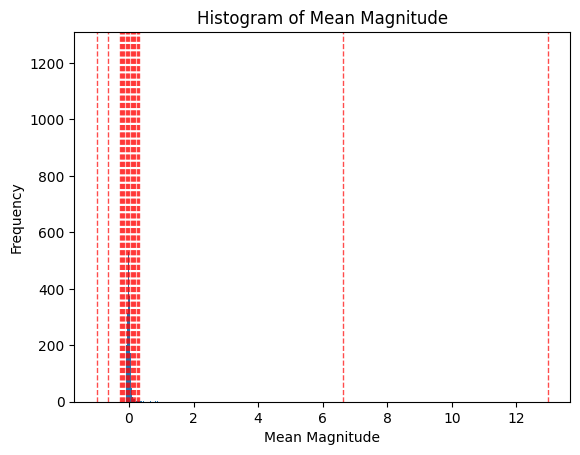

In [47]:
plt.hist(mean_m, bins=100)
plt.xlabel('Mean Magnitude')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Magnitude')

# Plot vertical lines for each cut point
for cut in cuts_c:
    plt.axvline(cut, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.show()

<h3> Different Cut Points

In [49]:
def assign_labels(values, cuts, labels):
    """
    Assigns to each value the label corresponding to the cut point closest to it.
    The cut point closest to 0 is always assigned the label ' ' (space).
    """
    cuts = np.array(cuts)
    labels = np.array(labels)

    # Find the cut point closest to 0 and set its label to ' '
    idx_zero = np.argmin(np.abs(cuts))
    labels = labels.copy()  # avoid modifying input
    labels[idx_zero] = ' '

    assigned = []
    for v in values:
        idx = np.argmin(np.abs(cuts - v))
        assigned.append(labels[idx])
    return assigned

In [51]:
import re

def labels_to_string(labels):
    """
    Convert a list of labels to a string, collapsing consecutive spaces into a single space.
    """
    s = ''.join(labels)
    return re.sub(r' +', ' ', s)

# Example usage:
# labels_seq = assign_labels(mean_m, cuts_a, labs_a)
# token_string = labels_to_string(labels_seq)
# print(token_string)

In [ ]:
labels_a=assign_labels(mean_m, cuts_a, labs_a)
string_a=labels_to_string(labels_a)

In [64]:
labels_s=assign_labels(mean_m, cuts_s, labs_s)
string_s=labels_to_string(labels_s)

In [65]:
labels_c=assign_labels(mean_m, cuts_c, labs_c)
string_c=labels_to_string(labels_c)

<h4>BPE 

In [ ]:
loaded_tokenizer_bert= AutoTokenizer.from_pretrained("gpt2")

In [ ]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# Build the tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(vocab_size=8000, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
corpus_iterator= string_c.split()
# Train on your own corpus
tokenizer.train_from_iterator(corpus_iterator, trainer)

# Encode
output = tokenizer.encode(string_c)
print(output.tokens)
print(len(output.ids))




['jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjiiiiiiiiiiiiijjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj', 'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj', 'jiiijjjjjjjjjjijiiiiiiiiiiiiiiiiiiiiiiii', 'oo', 'llj', 'jl', 'jjijj', 'lj', 'lq', 'mlmll', 'j', 'l', 'jjj', 'j', 'j', 'j', 'l', 'l', 'l', 'll', 'jj', 'l', 'm', 'ljjj', 'j', 'l', 'jj', 'm', 'o', 'jjjjj', 'prll', 'l', 'll', 'lm', 'llllljjjljl', 'jjhjijjsmjj', 'jjjjjijjjjjj', 'jiiiihhhhjj', 'iiiiijjihllllllllllll', 'l', 'jjiijj', 'm', 'lllllll', 'lllllllll', 'lmll', 'llmllllllllllmmmmmmmmmmlmmml', 'jjjiiijj', 'jjiiijllll', 'iij', 'jjj

Distribution of tokens

In [ ]:
encoded_outputs = [tokenizer.encode(text) for text in corpus_iterator]
token_ids = [token for enc in encoded_outputs for token in enc.ids]

In [ ]:
from collections import Counter

token_counts = Counter(token_ids)

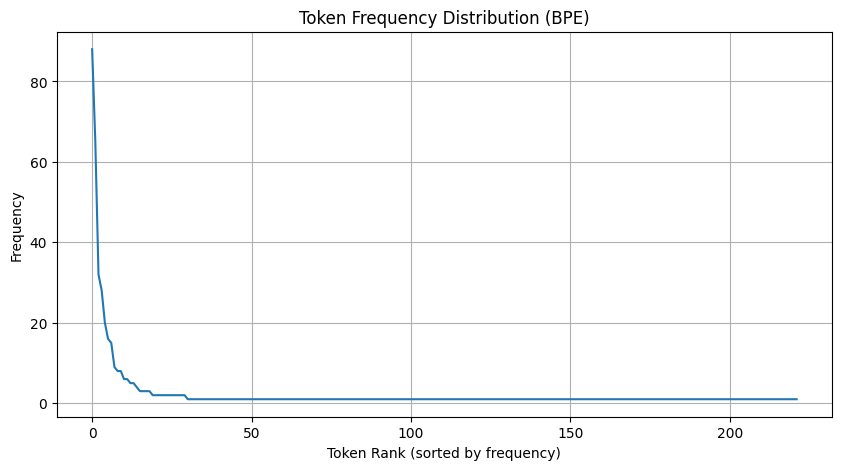

In [79]:
import matplotlib.pyplot as plt

# Sort tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
token_ids_sorted, frequencies = zip(*sorted_tokens)

plt.figure(figsize=(10, 5))
plt.plot(frequencies)
plt.xlabel("Token Rank (sorted by frequency)")
plt.ylabel("Frequency")
plt.title("Token Frequency Distribution (BPE)")
plt.grid(True)
plt.show()


<h2>Iterate through all Participants